# imports

In [2]:
import sys
sys.path.append('./lib')

import os
import h5py
import optuna

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Cdata/'
dirname = './Cdata/' # Working directory 

import numpy as np
import torch
import pickle
import os
import optuna
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import NDNLayer, ConvLayer, STconvLayer, Tlayer, ChannelLayer, IterSTlayer, ReadoutLayer
from NDNT.networks import FFnetwork
from time import time
import dill
import tqdm

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
import ColorDataUtils.mattplotlib
import ColorDataUtils.RFutils as RFutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:0")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

Running on Computer: [ca1]
Invoking __init__.py for NDNT.utils
Save_dir = ./Cdata/
cuda:0


# load data

In [2]:
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08_packaged'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
90.36267256736755 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [3]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
matdat = sio.loadmat(datadir+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

data.set_cells(valET)

174 out of 195 units used
Output set to 174 cells


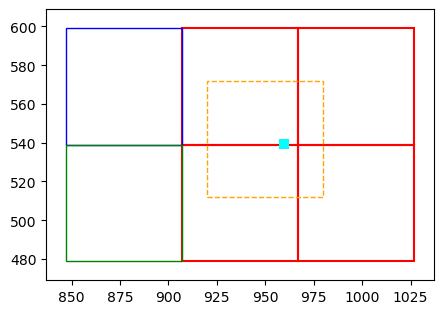

  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [4]:
# Load shifts and previous models
SHfile = sio.loadmat( datadir + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts, num_lags=num_lags)

In [5]:
goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))
matdat = sio.loadmat(datadir+'J0715ProcGLMinfo.mat')

data.dfs.shape

torch.Size([167520, 239])

# load GQMs

In [ ]:
folder = 'dan_gqms'
gqms = []
for i, cc in enumerate(range(NCv)):
    if i < 10:
        gqm_model_filename = 'models/'+folder+'/gqmU00'+str(cc)+'.pkl'
    elif i < 100:
        gqm_model_filename = 'models/'+folder+'/gqmU0'+str(cc)+'.pkl'
    else:
        gqm_model_filename = 'models/'+folder+'/gqmU'+str(cc)+'.pkl'
    if os.path.isfile(gqm_model_filename):
        # load the model and continue
        print('loading model', cc)
        with open(gqm_model_filename, 'rb') as f:
            gqm = pickle.load(f)
            gqms.append(gqm)

In [ ]:
# load LLS
LLinfo = None
with open('models/dan_gqms/LLinfo.mat', 'rb') as f:
    LLinfo = sio.loadmat(f)

LLinfo['ULLsNULL'].shape

In [ ]:
# # calculate the LL for each model
# LLs = []
# for cc, gqm in enumerate(tqdm.tqdm(gqms)):
#     LL = LLinfo['ULLsNULL'][0,cc] - gqm.eval_models(data[data.val_blks])[0]
#     LLs.append(LL)
# 
# with open('models/dan_gqms/LLs.pkl', 'wb') as f:
#     pickle.dump(LLs, f)
# 
# with open('models/dan_gqms/LLs.pkl', 'rb') as f:
#     LLs = pickle.load(f)

# complex and dir score

In [ ]:
complex_scores = []
direction_scores = []
direction_angles = []
direction_ims = []
for cc in tqdm.tqdm(range(len(gqms))):
    complex_score, _,_ = RFutils.GQM_complexity(gqms[cc], data, valET[cc], 0,2)
    dir_score, dir_angle, dir_im = RFutils.GQM_direction(gqms[cc], 0,2)
    complex_scores.append(complex_score)
    direction_scores.append(dir_score)
    direction_angles.append(dir_angle)
    direction_ims.append(dir_im)
complex_scores = np.array(complex_scores)
direction_scores = np.array(direction_scores)
direction_angles = np.array(direction_angles)

In [ ]:
# plot histogram of LLs
fig = plt.figure(figsize=(15,5))
plt.hist(LLs, bins=10)
plt.title('log-likelihoods')
plt.show()

# plot histogram of complex scores
fig = plt.figure(figsize=(15,5))
plt.hist(complex_scores, bins=10)
plt.title('complexity scores')
plt.show()

# plot histogram of direction scores
fig = plt.figure(figsize=(15,5))
plt.hist(direction_scores[direction_scores >= 0], bins=10)
plt.title('direction scores')
plt.show()

# plot histogram of direction scores
fig = plt.figure(figsize=(15,5))
plt.hist(direction_angles[direction_angles >= 0], bins=10)
plt.title('direction angles')
plt.show()

In [ ]:
np.where(direction_scores < 0)[0].shape

In [ ]:
# plot sample direction cells
# get top and bottom cells
cell_inds = []
#cell_inds.extend(np.flip(np.argsort(complex_scores)[::-1][-30:]))
#cell_inds.extend(np.flip(np.argsort(complex_scores)[::-1][:30]))
cell_inds.extend(np.flip(np.argsort(direction_scores)[::-1][-80:]))
cell_inds.extend(np.flip(np.argsort(direction_scores)[::-1][:30]))
for i in range(110):
    cc = cell_inds[i]
    
    if direction_scores[cc] < 0:
        continue
    
    linear = gqms[cc].networks[0].layers[0].get_weights()[:,:, :, 0]
    quad0 = gqms[cc].networks[2].layers[0].get_weights()[:,:, :, 0]
    quad1 = gqms[cc].networks[2].layers[0].get_weights()[:,:, :, 1]
    
    best_linear_lag = RFutils.get_best_lag(linear)
    best_quad0_lag = RFutils.get_best_lag(quad0)
    best_quad1_lag = RFutils.get_best_lag(quad1)
    
    print('complexity:', np.round(complex_scores[cc], 3), '| LL:', np.round(LLs[cc], 3), '| direction:', np.round(direction_scores[cc], 3), '| angle:', str(int(np.round(direction_angles[cc])))+'°')
    
    fig = plt.figure(figsize=(15,8))
    grid = plt.GridSpec(6, 4, wspace=0.4, hspace=0.8)
    ax = plt.subplot(grid[0, 0])
    if direction_ims[cc] is not None:
        plt.imshow(direction_ims[cc].T, aspect='auto', origin='lower', interpolation='none')
    for i, lag in enumerate(range(max(best_linear_lag-3,0), min(best_linear_lag+3,11))):
        ax = plt.subplot(grid[i, 1])
        if lag == best_linear_lag:
            ax.set_title('best lag: '+str(lag))
        else:
            ax.set_title('lag: '+str(lag))
        ax.imshow(linear[:,:, lag], aspect='auto', origin='lower', interpolation='none')
    for i, lag in enumerate(range(max(best_quad0_lag-3,0), min(best_quad0_lag+3,11))):
        ax = plt.subplot(grid[i, 2])
        if lag == best_quad0_lag:
            ax.set_title('best lag: '+str(lag))
        else:
            ax.set_title('lag: '+str(lag))
        ax.imshow(quad0[:,:, lag], aspect='auto', origin='lower', interpolation='none')
    for i, lag in enumerate(range(max(best_quad1_lag-3,0), min(best_quad1_lag+3,11))):
        ax = plt.subplot(grid[i, 3])
        if lag == best_quad1_lag:
            ax.set_title('best lag: '+str(lag))
        else:
            ax.set_title('lag: '+str(lag))
        ax.imshow(quad1[:,:, lag], aspect='auto', origin='lower', interpolation='none')
    plt.show()

# GLM/GQM functions

# load CNN

In [25]:
model_name = 'cnns_07'
num_models = 0
import glob
for file in glob.glob('models/'+model_name+'/cnn_*.pkl'):
    num_models += 1
print('num models:', num_models)

# make predictions from best CNN and best ITER
cnns = []
for i in range(0,num_models):
    with open('models/'+model_name+'/cnn_'+str(i)+'.pkl', 'rb') as f:
        cnns.append(pickle.load(f))

with open('models/'+model_name+'/study.pkl', 'rb') as f:
    study = pickle.load(f)
    
with open('models/'+model_name+'/pred.pkl', 'rb') as f:
    pred = pickle.load(f)

num models: 8


In [28]:
study.trials_dataframe()[study.trials_dataframe().value > 0.033]

,number,value,datetime_start,datetime_complete,duration,params_iter_filter_width,params_num_inh,params_num_iter,params_num_subs,params_proj_NLtype,params_proj_filter_width,system_attrs_fixed_params,state
1,1,0.033115,2023-07-30 09:35:46.970527,2023-07-30 10:43:49.061602,0 days 01:08:02.091075,9,0.4,5,38,lin,21,"{'proj_NLtype': 'lin', 'num_subs': 38, 'num_in...",COMPLETE


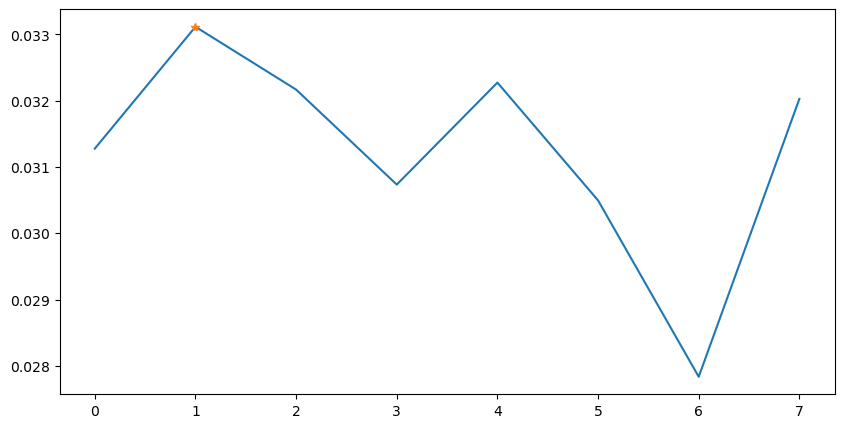

1


In [29]:
# plot LLs
fig = plt.figure(figsize=(10, 5))
plt.plot([np.mean(cnn.LLs) for cnn in cnns])
# put an asterisk on the best model
plt.plot(study.best_trial.number, np.mean(cnns[study.best_trial.number].LLs), '*')
plt.show()

best_cnn = cnns[study.best_trial.number].ndn_model
best_LLs = cnns[study.best_trial.number].LLs
best_trial = study.best_trial
print(study.best_trial.number)

In [30]:
best_cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([539, 4])
  Layer 1:
      weight: torch.Size([1764, 38])
  Layer 2:
      weight: torch.Size([3078, 38])
Network 1:
  Layer 0:
      weight: torch.Size([228, 174])
      NOT FIT: mu: torch.Size([174, 2])
      NOT FIT: sigma: torch.Size([174, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([44, 174])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 174])
      bias: torch.Size([174])


In [24]:
best_cnn.networks[0].layers[4].num_filters

31

## fit STAs from pred

In [10]:
#interesting_cells = [4,39,37,44,8,36]
interesting_cells = [4,37,8]

In [37]:
stas = []
for lag in range(1,8):
    Reff = torch.mul(pred, data.dfs[:pred.shape[0], valET])
    #Reff = torch.mul(data.robs[:, valET], data.dfs[:, valET])
    nspks = torch.sum(Reff, axis=0)
    stas.append(((data.stim[:pred.shape[0]-lag, :].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).detach().numpy())

STAs


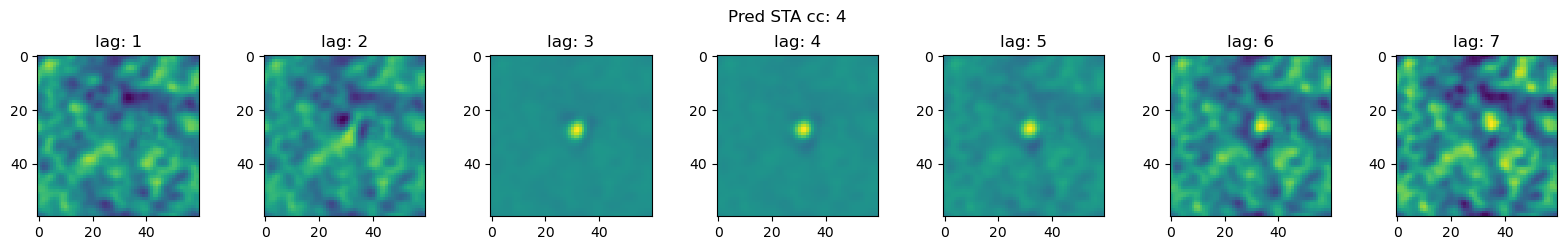

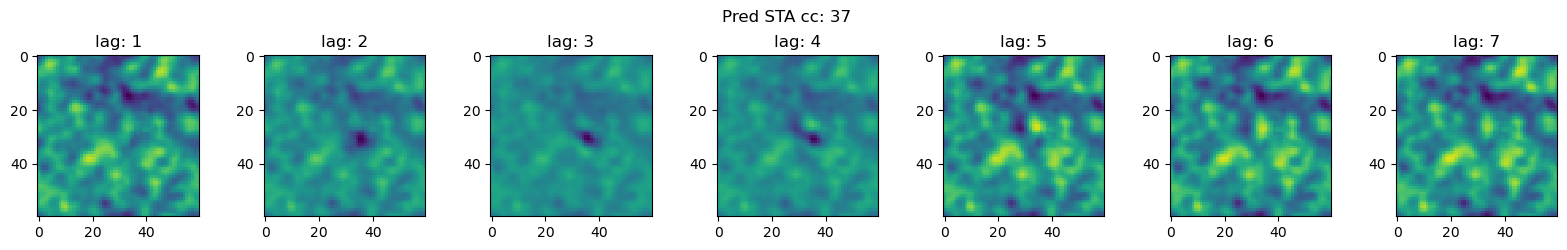

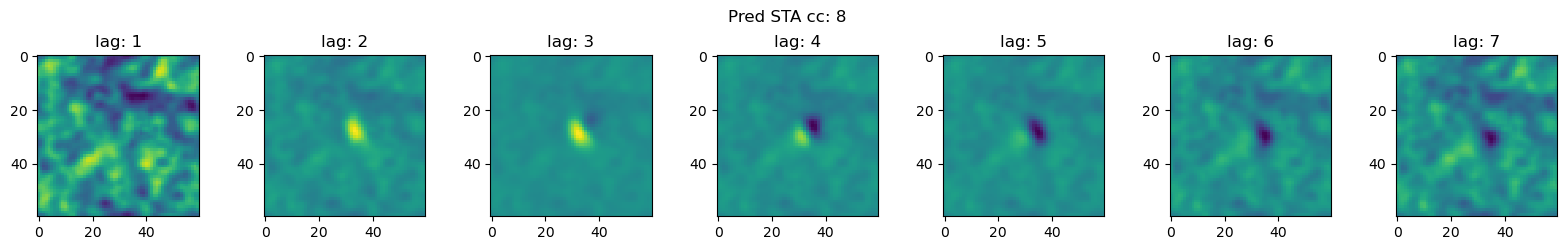

In [38]:
print("STAs")
for cc in interesting_cells:
    ss(1,7)
    col = 1
    for lag in range(len(stas)):
        plt.subplot(1,7, col)
        imagesc(stas[lag][:,:, cc])
        plt.title('lag: ' + str(lag+1))
        col += 1
    # adjust the plot down
    plt.subplots_adjust(top=0.8)
    plt.suptitle('Pred STA cc: ' + str(cc))
plt.show()

## fit Drifts from pred

In [11]:
# set the robs in the data to the predicted robs
data.robs = pred

In [12]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

In [13]:
num_lags = 16

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-8,
    tolerance_grad=1e-8,
    history_size=100,
    batch_size=20,
    max_epochs=3,
    max_iter=500,
    device=device)

folder = model_name+'/glms_pred'

In [14]:
drifts = []
for i, cc in enumerate(range(NCv)):
    drift_model_filename = 'models/'+folder+'/drift_model_cc'+str(cc)+'.pkl'
    # load drift and continue if it exists
    if os.path.exists(drift_model_filename):
        with open(drift_model_filename, 'rb') as f:
            drift_model = pickle.load(f)
        drifts.append(drift_model)
        continue
    data.set_cells(cc)
    drift_ndn = NDN.NDN(
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_ndn.block_sample=True
    drift_ndn.networks[0].xstim_n = 'Xdrift'
    drift_ndn.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LL = drift_ndn.eval_models(data[data.val_blks], null_adjusted=False)[0]
    drift_model = Model(drift_ndn, LL)
    drifts.append(drift_model)
    with open(drift_model_filename, 'wb') as f:
        pickle.dump(drift_model, f)

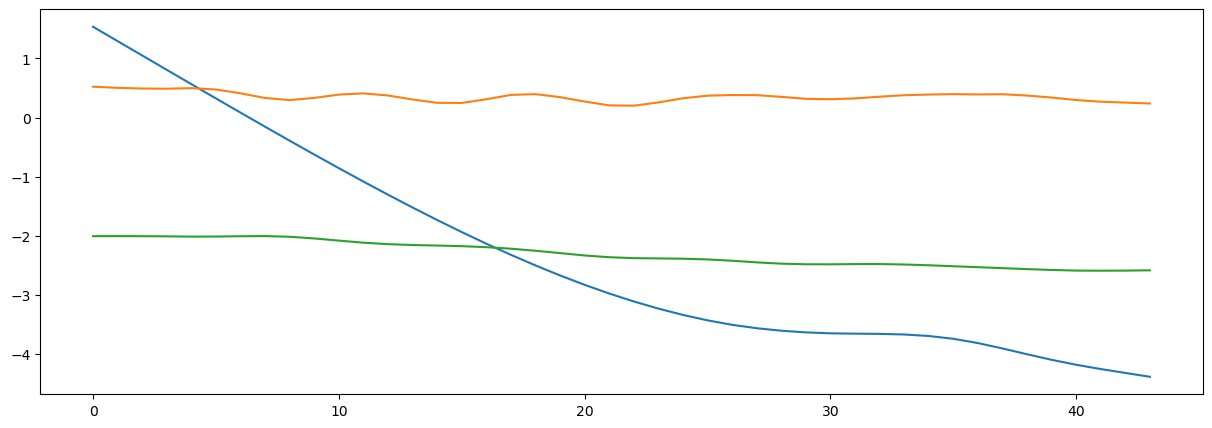

In [15]:
fig = plt.figure(figsize=(15,5))
for cc in interesting_cells:
    drift = drifts[cc]
    plt.plot(drift.ndn.networks[0].layers[0].get_weights())

## fit GLMs from pred

In [17]:
glms = []
for i, cc in enumerate(range(NCv)):
    glm_model_filename = 'models/'+folder+'/glm_model_cc'+str(cc)+'.pkl'
    # load GLM and continue if it exists
    if os.path.exists(glm_model_filename):
        with open(glm_model_filename, 'rb') as f:
            glm_model = pickle.load(f)
        glms.append(glm_model)
        continue
    data.set_cells(cc)
    LLsNULL = drifts[i].LLs
    glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    glm.block_sample=True
    drift_weights = drifts[i].ndn.networks[0].layers[0].weight.data[:,0]
    glm.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
    glm.networks[1].layers[0].set_parameters(val=False)
    glm.networks[2].layers[0].set_parameters(val=False,name='weight')
    glm.fit(data, force_dict_training=True, **lbfgs_pars)
    LL = glm.eval_models(data[data.val_blks], null_adjusted=False)[0]
    null_adjusted_LL = LLsNULL - LL
    glm_model = Model(glm, null_adjusted_LL)
    glms.append(glm_model)
    with open(glm_model_filename, 'wb') as f:
        pickle.dump(glm_model, f)

Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 16.899700164794922 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 13.087477684020996 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.423220872879028 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 149.56343507766724 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 20.42304253578186 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.750133991241455 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 12.301226615905762 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.363875389099121 sec elapsed
Output set to 1 cells

GPU Available: True, GPU Us


KeyboardInterrupt



In [ ]:
for i, cc in enumerate(interesting_cells):
    max_weights = np.max(glms[i].ndn.networks[0].layers[0].get_weights())
    ss(1,7)
    col = 1
    for lag in range(num_lags-2, num_lags-9, -1):
        plt.subplot(1,7, col)
        imagesc(glms[i].ndn.networks[0].layers[0].get_weights()[:,:, lag, 0], max=max_weights)
        plt.suptitle('Pred GLM, cc:' + str(cc) + ' -- ' + str(valET[cc]) + ' LL: ' + str(glms[i].LLs))
        col += 1
    plt.show()

## fit GQMs from pred

In [ ]:
gqms = []
for i, cc in enumerate(range(NCv)):
    gqm_model_filename = 'models/'+folder+'/gqm_model_cc'+str(cc)+'.pkl'
    drift_weights = drifts[i].ndn.networks[0].layers[0].weight.data[:,0]
    data.set_cells(cc)

    LLsNULL = drifts[i].LLs

    # get the best reg_vals for the GLM
    best_reg_vals = glms[i].ndn.networks[0].layers[0].reg.vals

    # get the best reg_vals for the GLM
    stim_net['layer_list'][0]['reg_vals'] = deepcopy(best_reg_vals)

    gqm = NDN.NDN(ffnet_list = [stim_net, drift_net, stim_qnet, net2_comb], loss_type='poisson')
    gqm.networks[0].layers[0] = deepcopy(glms[i].ndn.networks[0].layers[0])
    gqm.block_sample=True
    gqm.networks[3].layers[0].set_parameters(val=False,name='weight')
    gqm.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
    gqm.networks[1].layers[0].set_parameters(val=False)

    gqm.fit(data, force_dict_training=True, **lbfgs_pars)
    LL = gqm.eval_models(data[data.val_blks], null_adjusted=False)[0]

    null_adjusted_LL = LLsNULL - LL

    gqm_model = Model(gqm, null_adjusted_LL)
    gqms.append(gqm_model)

    with open(gqm_model_filename, 'wb') as f:
        pickle.dump(gqm_model, f)

In [ ]:
# plot filters
for i, cc in enumerate(interesting_cells):
    max_weights = 0
    weights_lin = np.max(gqms[i].ndn.networks[0].layers[0].get_weights())
    weights_quad = np.max(gqms[i].ndn.networks[2].layers[0].get_weights())
    if weights_lin > max_weights:
        max_weights = weights_lin
    if weights_quad > max_weights:
        max_weights = weights_quad

    print('-------------')
    ss(1,7)
    col = 1
    for lag in range(num_lags-2, num_lags-9, -1):
        plt.subplot(1,7, col)
        imagesc(gqms[i].ndn.networks[0].layers[0].get_weights()[:,:, lag, 0], max=max_weights)
        plt.suptitle('Pred GQM - linear, cc:' + str(cc) + ' -- ' + str(valET[cc]) + ' LL: ' + str(gqms[i].LLs))
        col += 1
    ss(1,7)
    col = 1
    for lag in range(num_lags-2, num_lags-9, -1):
        plt.subplot(1,7, col)
        imagesc(gqms[i].ndn.networks[2].layers[0].get_weights()[:,:, lag, 0], max=max_weights)
        plt.suptitle('Pred GQM - quad0, cc:' + str(cc) + ' -- ' + str(valET[cc]))
        col += 1
    ss(1,7)
    col = 1
    for lag in range(num_lags-2, num_lags-9, -1):
        plt.subplot(1,7, col)
        imagesc(gqms[i].ndn.networks[2].layers[0].get_weights()[:,:, lag, 1], max=max_weights)
        plt.suptitle('Pred GQM - quad1, cc:' + str(cc) + ' -- ' + str(valET[cc]))
        col += 1
    plt.show()